In [1]:
import datetime
import sys, os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
import scanpy as sc
sc.logging.print_memory_usage()
sc.settings.verbosity = 2
sc.settings.set_figure_params(dpi = 300, dpi_save = 300)
sc.logging.print_header()

from matplotlib.pyplot import rc_context

Memory usage: current 0.21 GB, difference +0.21 GB
scanpy==1.10.1 anndata==0.10.7 umap==0.5.5 numpy==1.26.4 scipy==1.13.0 pandas==2.0.3 scikit-learn==1.4.2 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.12


In [3]:
# add the utility functions folder to PATH
sys.path.append(os.path.abspath("../packages"))
from db_dev.helper import *

In [4]:
home_dir = os.path.expanduser("~")

In [5]:
adata = sc.read_h5ad("/Users/denis/microtechnologies/sequencing/241030_FACS1/backups/mito_total_counts_filt_doublet_26287x37733_241031_14h36.h5ad")

In [7]:
#subset adata without doublets
print(len(adata))
adata = adata[adata.obs["predicted_doublet"] == False]
print(len(adata))


26287
25260


In [8]:
adata.var["mt"] = adata.var_names.str.startswith(("MT-")) # annotate the group of mitochondrial genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS","RPL")) # annotate the group of ribo genes
#adata.var["hb"] = adata.var_names.str.contains(("GRCh38_^HB[^(P)]")) # hemoglobin genes

# Saving raw (original) counts to layer
adata.layers["counts"] = adata.X.copy()

#save "raw" data (not scalled, not log)
adata.raw = adata

#calculate qc metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo"], percent_top = None, log1p = False, inplace = True)

#normalize data
sc.pp.normalize_per_cell(adata, counts_per_cell_after = 1e4) # n_counts is created


/var/folders/sv/fwsrf8xs57jd9rtwwfxmyxg80000gn/T/ipykernel_5514/4021811915.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["mt"] = adata.var_names.str.startswith(("MT-")) # annotate the group of mitochondrial genes


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [9]:
adata.layers["counts"].sum(axis = 1)

matrix([[  452.],
        [13948.],
        [ 4773.],
        ...,
        [ 1543.],
        [  404.],
        [ 5833.]], dtype=float32)

In [10]:
adata.raw.X.sum(axis = 1)

matrix([[  452.],
        [13948.],
        [ 4773.],
        ...,
        [ 1543.],
        [  404.],
        [ 5833.]], dtype=float32)

In [11]:
adata.X.sum(axis = 1)

matrix([[10000.001],
        [10000.   ],
        [10000.002],
        ...,
        [10000.   ],
        [10000.   ],
        [10000.001]], dtype=float32)

In [12]:
cdata = adata.copy()

In [13]:
# avoid genes starting with
toavoid = ["MT-", "RPS","RPL","MRPL", "MRPS"]
for i in toavoid:
    print(i)
    print([g for g in cdata.var_names if g.startswith(i)])
    print("\n")

MT-
['MT-ND1', 'MT-ND2', 'MT-CO1', 'MT-CO2', 'MT-ATP8', 'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB']


RPS
['RPS6KA1', 'RPS8', 'RPS27', 'RPS6KC1', 'RPS7', 'RPS27A', 'RPSA', 'RPS3A', 'RPS23', 'RPS14', 'RPS18', 'RPS10-NUDT3', 'RPS10', 'RPS12', 'RPS6KA2', 'RPS6KA2-IT1', 'RPS6KA2-AS1', 'RPS20', 'RPS6', 'RPS24', 'RPS13', 'RPS6KA4', 'RPS6KB2', 'RPS6KB2-AS1', 'RPS3', 'RPS25', 'RPS26', 'RPS29', 'RPS6KL1', 'RPS6KA5', 'RPS27L', 'RPS17', 'RPS2', 'RPS15A', 'RPS6KB1', 'RPS15', 'RPS28', 'RPSAP58', 'RPS16', 'RPS19', 'RPS11', 'RPS9', 'RPS5', 'RPS21', 'RPS19BP1', 'RPS6KA3', 'RPS4X', 'RPS6KA6', 'RPS4Y1', 'RPS4Y2']


RPL
['RPL22', 'RPL11', 'RPL5', 'RPL31', 'RPL37A-DT', 'RPL37A', 'RPL32', 'RPL15', 'RPL14', 'RPL29', 'RPL24', 'RPL22L1', 'RPL39L', 'RPL35A', 'RPL9', 'RPL34-DT', 'RPL34', 'RPL37', 'RPL26L1-AS1', 'RPL26L1', 'RPL10A', 'RPL7L1', 'RPL7', 'RPL30', 'RPL30-AS1', 'RPL8', 'RPL35', 'RPL12', 'RPL7A', 'RPLP2', 'RPL27A', 'RPL41', 'RPL6', 'RPLP0', 'RPL21', 'RPL10L', 'RPL3

In [14]:
filter_genes = ["MT-", "RPS","RPL","MRPL", "MRPS"]

print("before mt and ribo removal: ", cdata.n_obs, cdata.n_vars)

mask_gene_list = []
for gene in filter_genes:
    mask_gene = cdata.var_names.str.startswith(gene)
    mask_gene_list.append(mask_gene)
    #remove = np.add(mask_gene)
    
remove = np.sum(mask_gene_list, axis = 0, dtype = bool) 
keep = np.invert(remove)
keep
cdata = cdata[:,keep]

print("after mt and ribo removal: ", cdata.n_obs, cdata.n_vars)

before mt and ribo removal:  25260 37733
after mt and ribo removal:  25260 37528


In [16]:
######min_cells = 5, min_counts = 10######
# Filtering "noisy" genes
gmask = filter_abund_genes(E = cdata.X, min_cells = 5, min_counts = 10)

15218 genes passing abundance filter


In [17]:
cdata = cdata[:,gmask]

extracting highly variable genes


/Users/denis/mambaforge/envs/capseq_seurat_v3/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:163: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


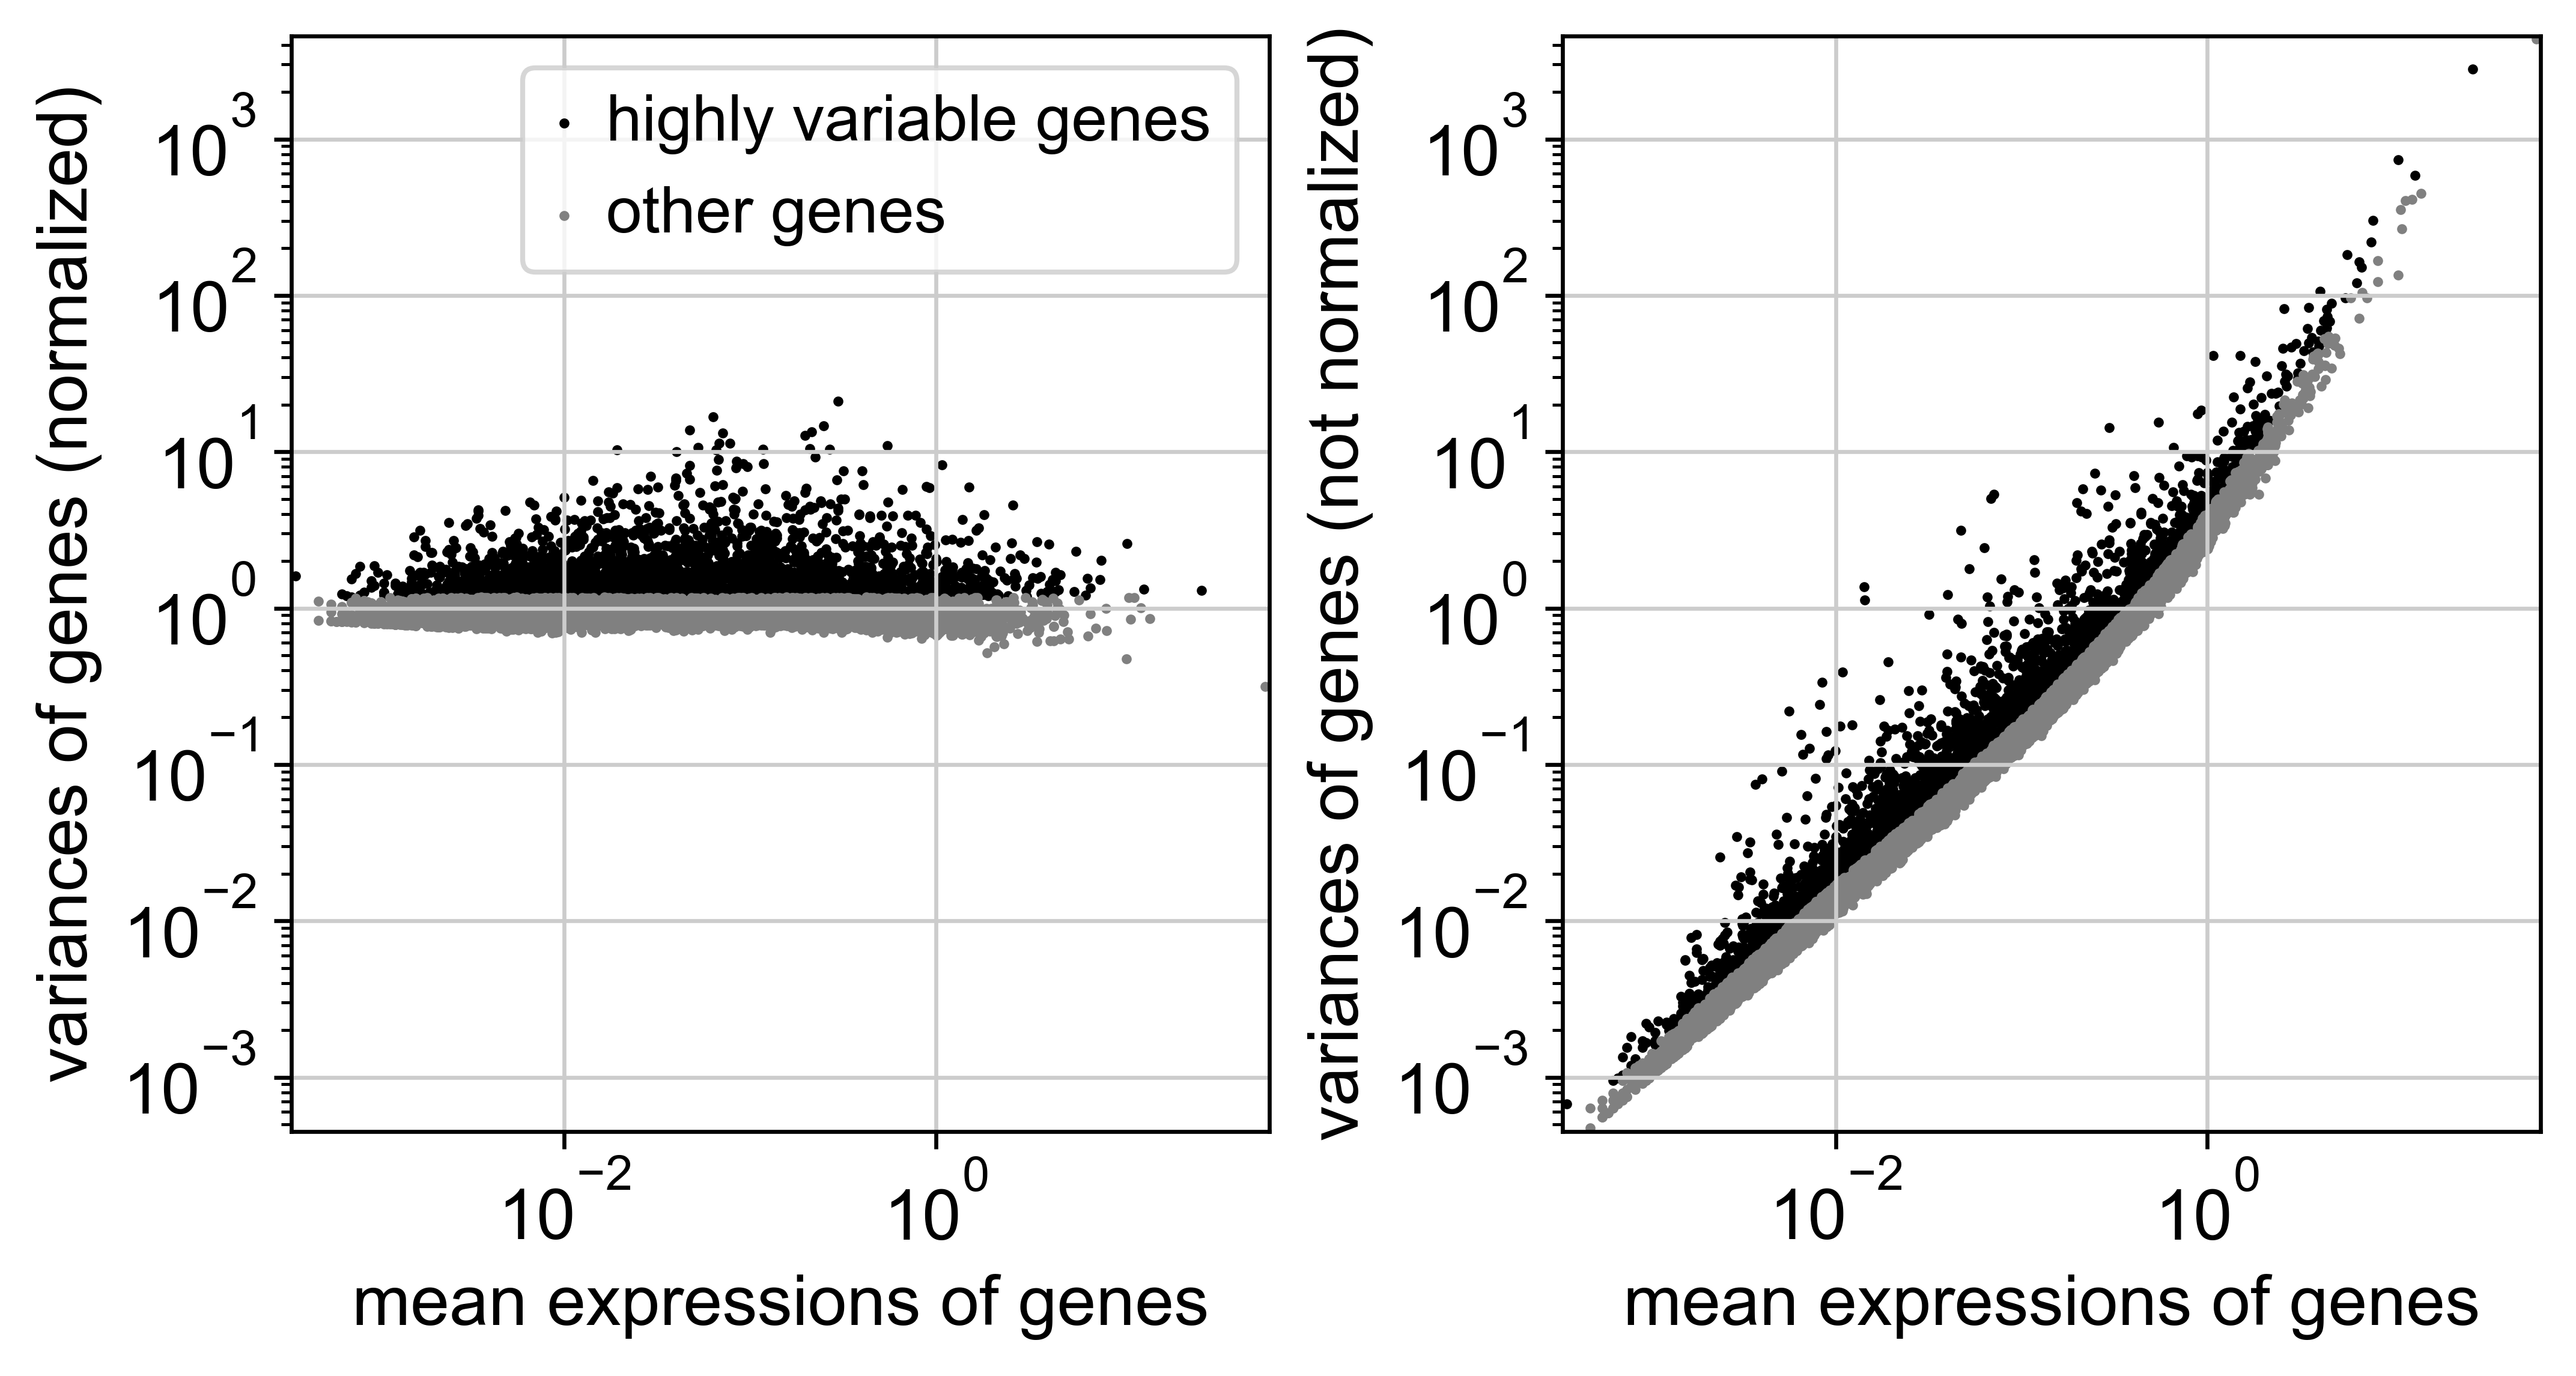

In [18]:
#Identify highly variable genes


sc.pp.highly_variable_genes(cdata, 
                            n_top_genes = 2500, 
                            flavor="seurat_v3",#_paper", 
                            layer = "counts")


sc.pl.highly_variable_genes(cdata, save = "_seurat_v3_2500_without_log1p_all_samples.png", log = True)



In [19]:
#Select only highly variable genes
cdata = cdata[:, cdata.var.highly_variable]

In [20]:
# Z-score
sc.pp.scale(cdata, max_value = 10)

/Users/denis/mambaforge/envs/capseq_seurat_v3/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:299: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [21]:
# find the number of non-random PCs

Z = cdata.X
d = find_num_pc(Z, start_pc = 200, sparse = False)
print ("Number of pc to use for is : "  + str(d["num_pc"]))
# now use the calculated number of PCAs and neighbours for each anndata object

sc.tl.pca(cdata, n_comps = d["num_pc"], svd_solver = "arpack")


calculating the first 200 observed eigenvalues...
calculating the random eigenvalues for 10 rounds of shuffling...
1 	 45 	 0.29 min.
2 	 45 	 0.51 min.
3 	 45 	 0.72 min.
4 	 45 	 0.94 min.
5 	 45 	 1.16 min.
6 	 45 	 1.38 min.
7 	 45 	 1.59 min.
8 	 45 	 1.82 min.
9 	 45 	 2.14 min.
10 	 45 	 2.35 min.
Number of pc to use for is : 45
computing PCA
    with n_comps=45
    finished (0:00:03)


In [25]:
sc.pp.neighbors(cdata, n_neighbors = 15)
sc.tl.umap(cdata, min_dist = 0.3, random_state = 69)

computing neighbors
    using 'X_pca' with n_pcs = 45
    finished (0:00:13)
computing UMAP
    finished (0:00:13)


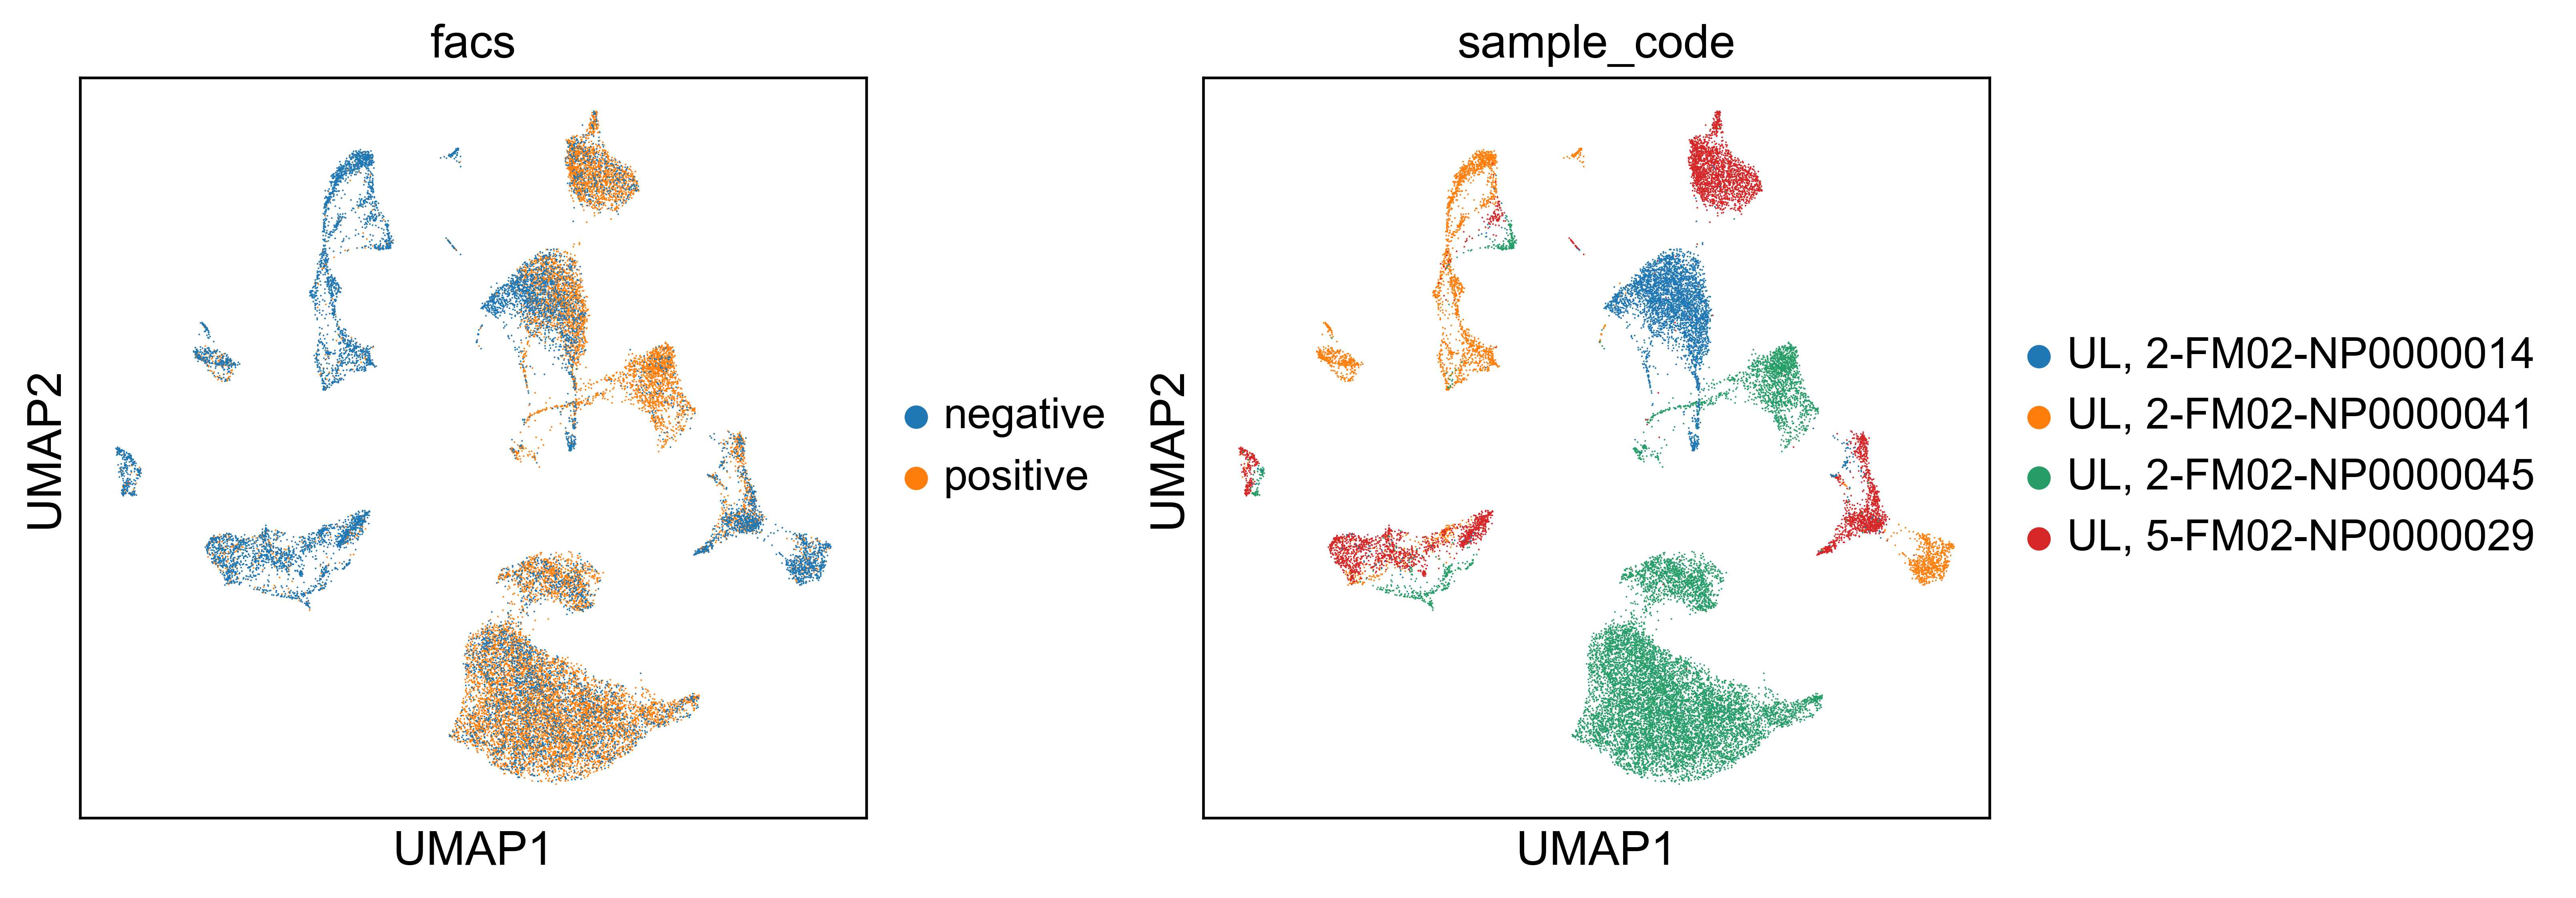

In [26]:
sc.pl.umap(cdata, color = ["facs", "sample_code"], 
           alpha = 1, 
           wspace = 0.3,
           ncols = 2,
           s = 1,
           save = "_no_bach_correction_2500hvg_5cells_10counts_15neighbors_0.3min_dist_NOlog1p_all_samples.png")


In [27]:
#Batch correction
sc.external.pp.harmony_integrate(cdata, ["code"], max_iter_harmony = 20)
sc.pp.neighbors(cdata, n_neighbors = 15, use_rep = "X_pca_harmony")
sc.tl.umap(cdata, min_dist = 0.3, random_state = 69)


2025-02-11 13:20:04,938 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-02-11 13:20:07,042 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-02-11 13:20:07,136 - harmonypy - INFO - Iteration 1 of 20
2025-02-11 13:20:12,814 - harmonypy - INFO - Iteration 2 of 20
2025-02-11 13:20:17,491 - harmonypy - INFO - Iteration 3 of 20
2025-02-11 13:20:22,013 - harmonypy - INFO - Iteration 4 of 20
2025-02-11 13:20:26,144 - harmonypy - INFO - Iteration 5 of 20
2025-02-11 13:20:31,066 - harmonypy - INFO - Iteration 6 of 20
2025-02-11 13:20:35,686 - harmonypy - INFO - Iteration 7 of 20
2025-02-11 13:20:40,409 - harmonypy - INFO - Converged after 7 iterations


computing neighbors
    finished (0:00:02)
computing UMAP
    finished (0:00:16)


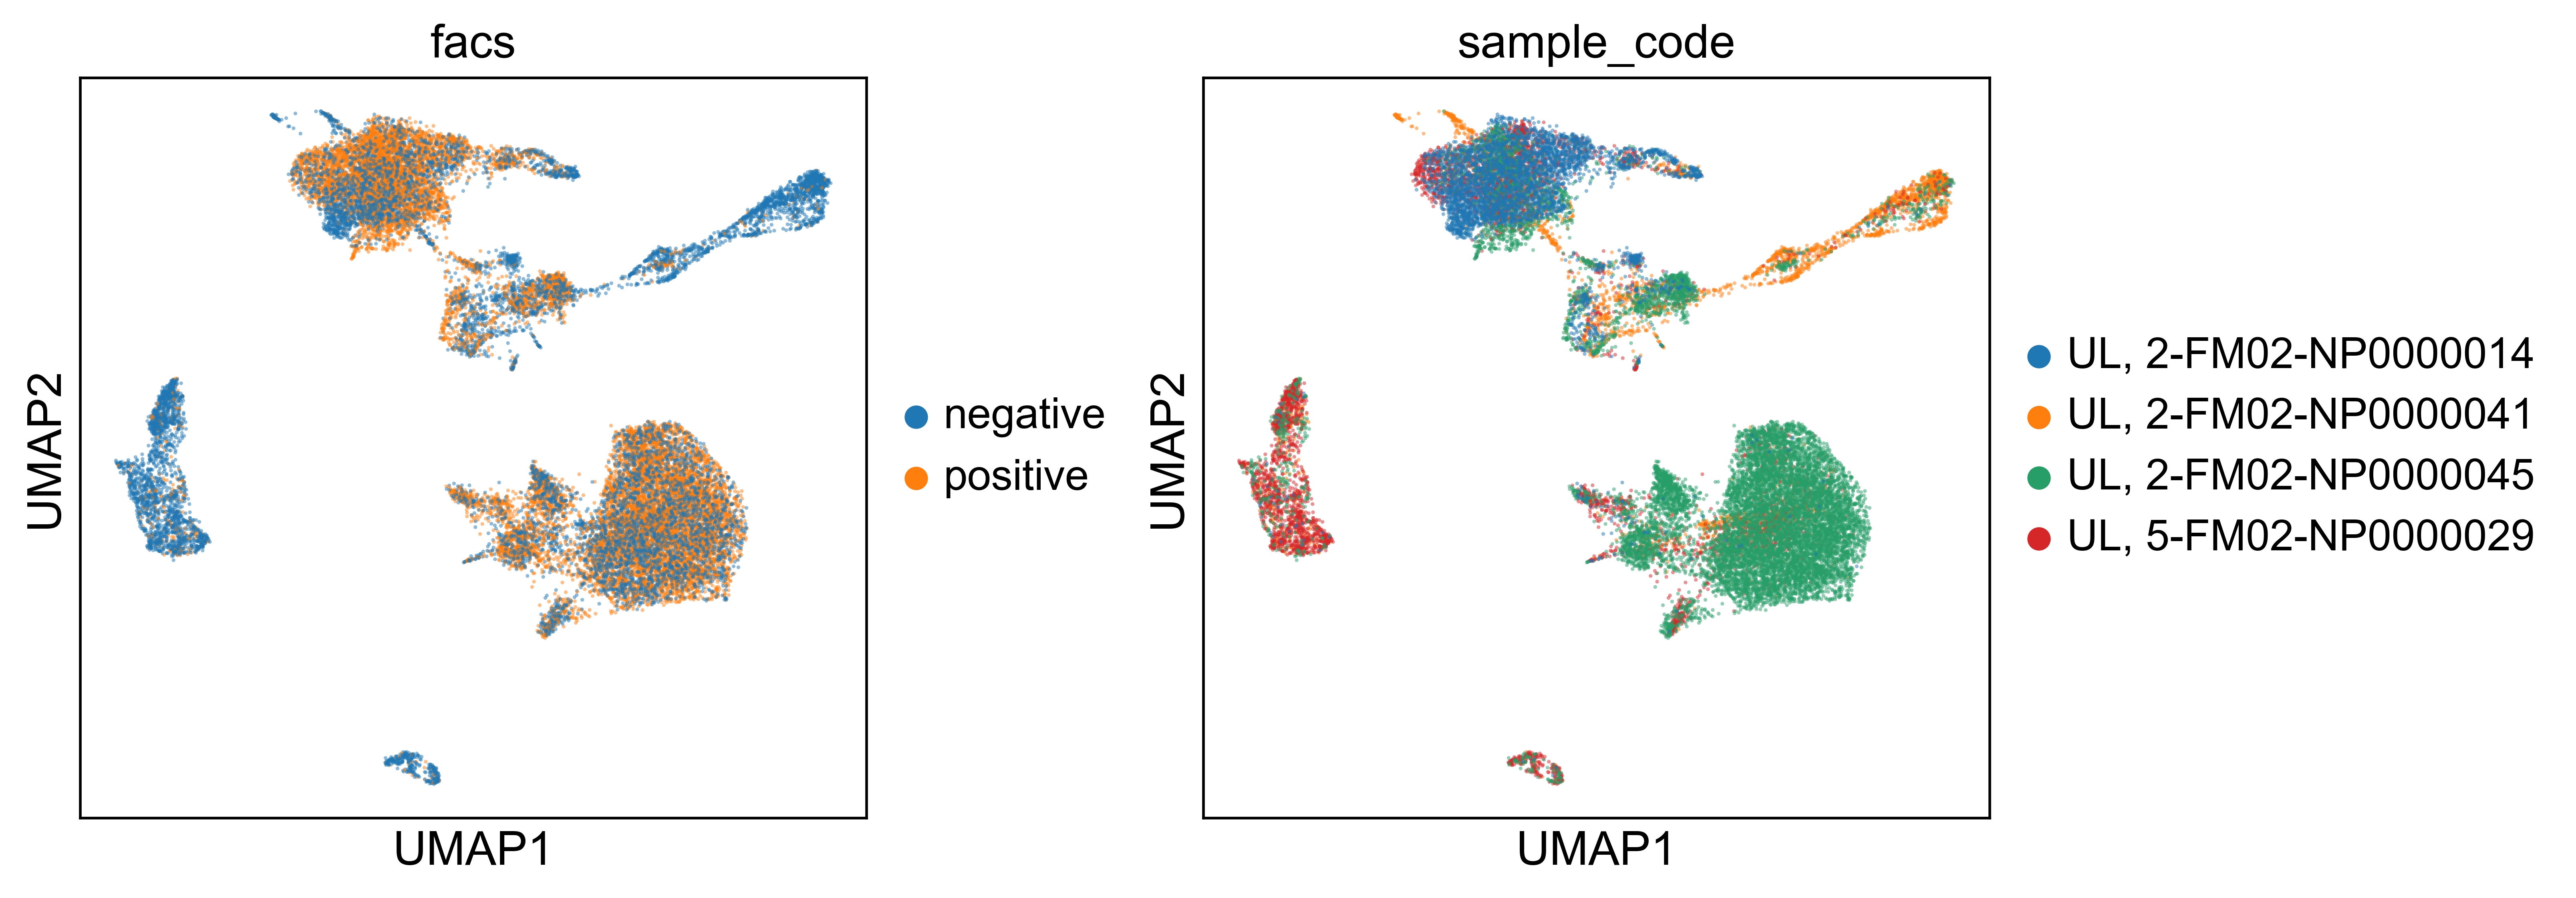

In [28]:
sc.pl.umap(cdata, color = ["facs","sample_code"], 
           alpha = 0.5, 
           wspace = 0.3,
           ncols = 2,
           s = 5,
           save = "_bach_correction_2500hvg_5cells_10counts_15neighbors_0.3min_dist_NOlog1p_all_samples.png")


In [30]:
import seaborn as sns

In [ ]:
# Choosing the best UMAP parameters
neighbor_list = [15, 20, 30, 40, 50]
dist_list = [0.15, 0.2, 0.3, 0.4]

for j in neighbor_list:
    k = j
    print(k, "neighbors")
    sc.pp.neighbors(cdata, k, use_rep = "X_pca_harmony")
    for i in dist_list:
        sc.tl.umap(cdata, min_dist = i, random_state = 69)
        mpl.rcParams["figure.figsize"] = (5,5)
        sc.pl.umap(cdata, color = ["facs", "MIR181A1HG", "sample_code"], 
                   layer = "counts", use_raw = False,
                   alpha = 1, s = 3, wspace = 0.3, ncols = 3, 
                   vmax = "15", cmap=sns.cubehelix_palette(dark=0, light=.9, as_cmap=True),
                   title = 'neighbors = %s, dist = %s'% (j, i))
        
# Not saving output figures, as they take too much space  

computing neighbors
    finished (0:00:07)
computing UMAP
    finished (0:00:18)


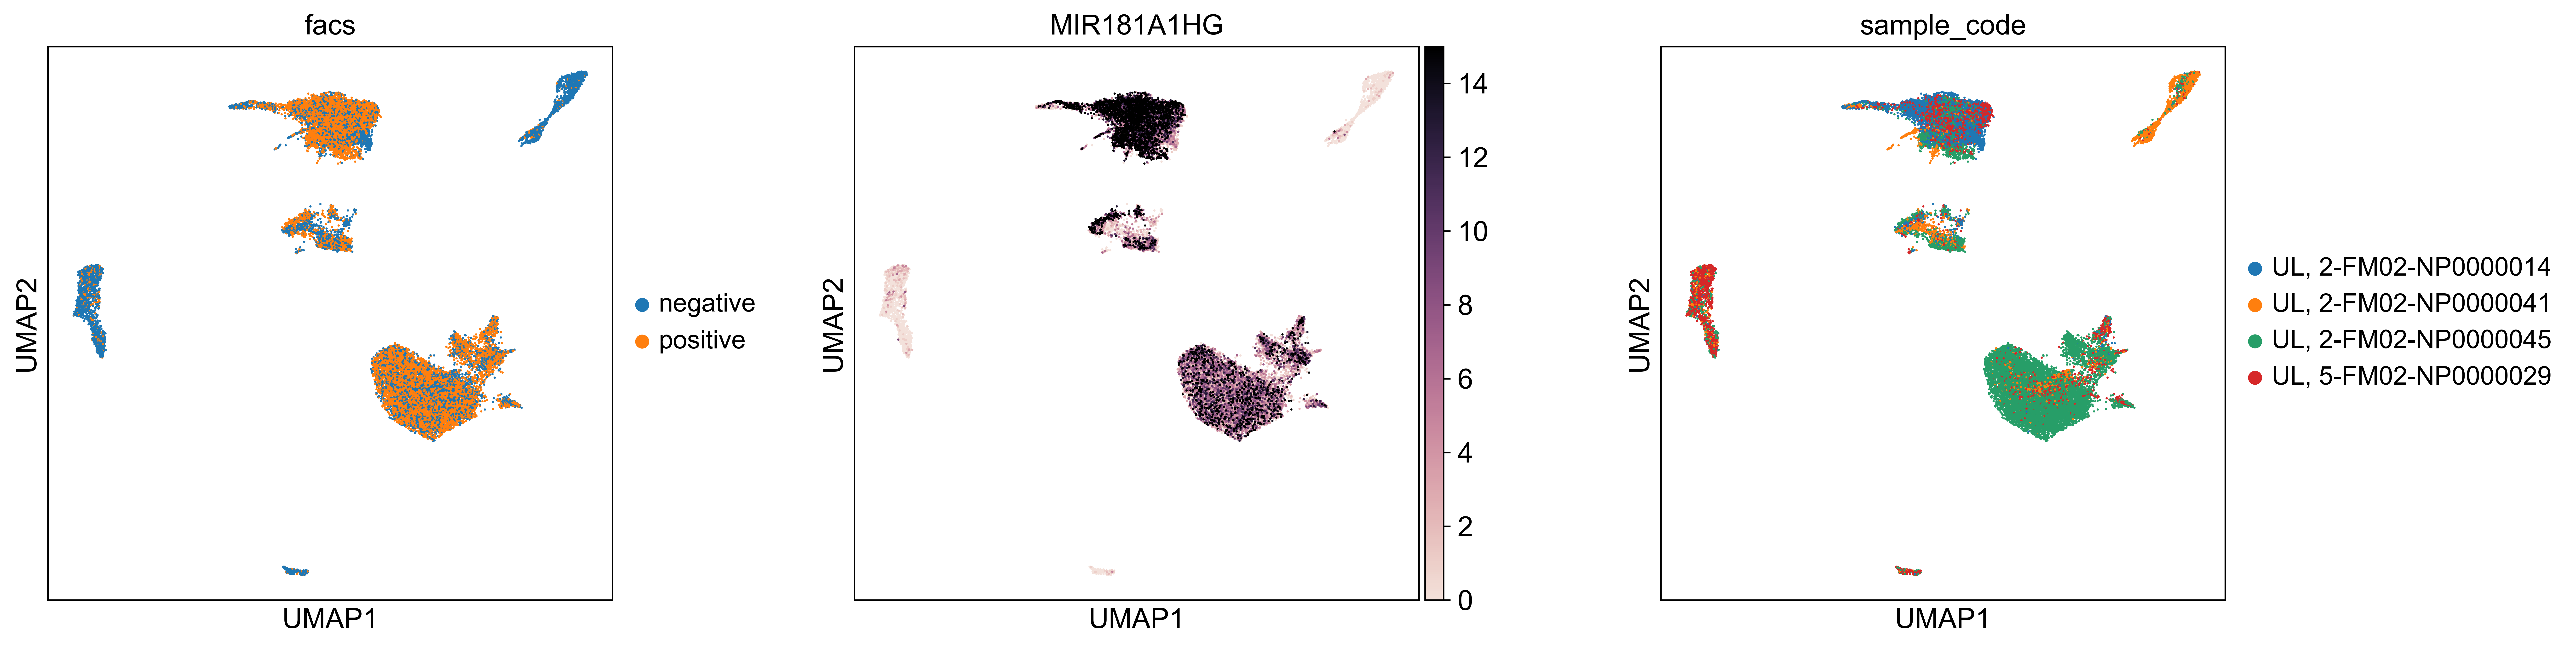

In [77]:
sc.pp.neighbors(cdata, n_neighbors = 50, use_rep = "X_pca_harmony")
sc.tl.umap(cdata, min_dist = 0.15, random_state = 69)

np.random.seed(69)
random_indices = np.random.permutation(list(range(cdata.shape[0])))

sc.pl.umap(cdata[random_indices, :], color = ["facs", "MIR181A1HG", "sample_code"], 
           alpha = 1, 
           wspace = 0.3,
           ncols = 3,
           s = 5,
           layer = "counts", use_raw=False,
           vmax = "15", cmap=sns.cubehelix_palette(dark=0, light=.9, as_cmap=True),
           save = "_bach_correction_2500hvg_5cells_10counts_50neighbors_0.15min_dist_filtered_all_samples.png")

In [82]:
#saving hvg genes
cdata.uns["hvg_list"] = list(cdata[:, cdata.var.highly_variable].var.highly_variable.index)


In [83]:
# saving recovered, batch corrected and filtered umap with optimal parameters before leiden clustering


cdata = cdata.raw.to_adata()
# Saving raw (original) counts to layer
cdata.layers["counts"] = cdata.X.copy()
# Save log-norm into .X
#normalize data
sc.pp.normalize_per_cell(cdata, counts_per_cell_after = 1e4) # n_counts is created
#logaritmize data
sc.pp.log1p(cdata)

fname1 = "backups/facs1_norm_filtered_NOlog1p_hvg_z_pca_harmony_after_filtering_and_doublet_filtered_all_samples_50neighbors_0.15dist_%dx%d_%s.h5ad"%(cdata.shape[0],cdata.shape[1],now())
print(fname1)
cdata.write(fname1)


normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
backups/facs1_norm_filtered_NOlog1p_hvg_z_pca_harmony_after_filtering_and_doublet_filtered_all_samples_50neighbors_0.15dist_25260x37733_250211_16h12.h5ad
